<a href="https://colab.research.google.com/github/lima-breno/data_wrangling/blob/main/DW_11_An%C3%A1lise_dados_com_SQL_PROJETO_Meteora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [ ]:
#importando as bibliotecas utilizdas
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text



**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [ ]:
################
#A IDEIA DESSA AULA É FAZER A NORMALIZAÇÃO DOS DADOS, NADA SE RELACIONA A MANIPULAÇÃO DAS TABELAS
#################

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Definindo os dados
itens_pedidos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Curso 02 - Avançado em Python/1.7 Python: Análise de dados com SQL/Dados utilizados/itens_pedidos.csv')
pedidos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Curso 02 - Avançado em Python/1.7 Python: Análise de dados com SQL/Dados utilizados/pedidos.csv')
produtos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Curso 02 - Avançado em Python/1.7 Python: Análise de dados com SQL/Dados utilizados/produtos.csv')
vendedores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Curso 02 - Avançado em Python/1.7 Python: Análise de dados com SQL/Dados utilizados/vendedores.csv')

###Alocando as tabelas no SQLite

In [ ]:
#ALOCAÇÃO DE TABELAS NO BANCO DE DADOS
## Para isso, podemos fazer um banco de dados local para armazenar as tabelas
engine = create_engine('sqlite:///:memory:')

In [ ]:
# Adicionando as tabelas no banco de dados
    #Conteudo dentro do comando:
      # nome da tabela= produtos

produtos.to_sql('produtos', engine, index=False)
# Ele retorna a quantidade de linhas salva na Tabela

205

In [ ]:
#Repetindo o processo para as demais tabelas
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)
# Aqui ele retorna a qtd de linhas do ultimo comando

5

In [ ]:
#Inspecionar para ver se as tabelas foram adicionadas
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [ ]:
#Verificando o padrao de produtos da empresa
#Verificando a condição dos produtos

#Criando a pesquisa
query = 'SELECT CONDICAO FROM PRODUTOS'

In [ ]:
#FAZENDO UMA CONEXAO COM A ENGINE PARA EXECUTAR A QUERY
with engine.connect() as conexao:
  consulta = conexao.execute(text(query)) # o text funciona para eenviar a variavel query como texto
  dados = consulta.fetchall() #aqui faz com que seja retornado um DF com os dados da consulta, armazenando como listas ou tuplas

#criando o DF dos dados deixando apenas as colunas das condicoes
pd.DataFrame(dados, columns= consulta.keys()) #

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [ ]:
# dá para deixar o código acima como uma função, pois é muito utilizado

def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
  return pd.DataFrame(dados, columns= consulta.keys())

In [ ]:
#entendendo a distribuição das categorias por recorrencia(agrupando as categorias por frequencia)

query = '''SELECT CONDICAO AS "Condição", COUNT(*) AS "Quantidade"
FROM PRODUTOS
GROUP BY CONDICAO;'''


df_produtos = sql_df(query)
df_produtos

,Condição,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


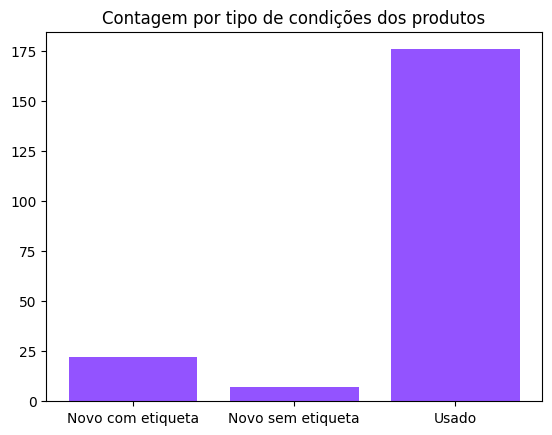

In [ ]:
#Criando um grafico

plt.bar(df_produtos['Condição'], df_produtos['Quantidade'], color = '#9353FF')
plt.title('Contagem por tipo de condições dos produtos')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [ ]:
#Fazendo a correlação com o nome do produo e a sua qtd
  #É necessário fazer uma relaçao das tabelas produros e itens pedidos

sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [ ]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [ ]:
#fazendo a query que relaciona essas tabelas e somando os produtos por qtd
query = '''SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS 'Quantidade'
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC'''

df_prod_quant = sql_df(query)
df_prod_quant

,produto,Quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


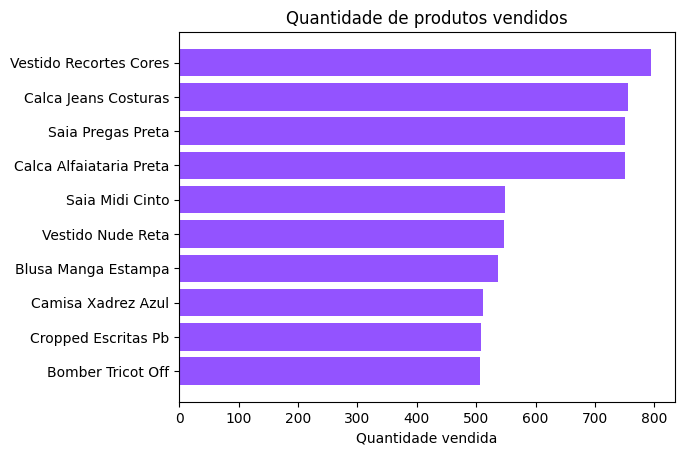

In [ ]:
plt.barh(df_prod_quant['produto'][-10:], df_prod_quant['Quantidade'][-10:], color = '#9353FF')
plt.xlabel('Quantidade vendida')
plt.title('Quantidade de produtos vendidos')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [ ]:
sql_df('SELECT * FROM PEDIDOS').head()

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [ ]:
sql_df('SELECT * FROM PEDIDOS').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

In [ ]:
#o dado da data está como objeto, podemos fazer o filtro de pesquisa do ano or meio do SQL -> strftime (
    #Isso é possível pois o dado está em AAAA-MM-DD

query = ''' SELECT *
FROM PEDIDOS
WHERE strftime('%Y', data_compra) = '2020'
'''


sql_df(query)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,112772,84743,3,2020-01-01,720
1,112909,56350,3,2020-01-01,1225
2,113068,70673,2,2020-01-01,1050
3,113453,16634,3,2020-01-01,2880
4,114487,43054,1,2020-01-01,640
...,...,...,...,...,...
14540,26762,9981,4,2020-12-31,8000
14541,27016,20029,3,2020-12-31,1764
14542,27666,12895,5,2020-12-31,10400
14543,28206,29893,4,2020-12-31,2100


In [ ]:
# Agrupando os dados pelo ID_vendedor
query = ''' SELECT VENDEDOR_ID, COUNT(*)
FROM PEDIDOS
WHERE strftime('%Y', data_compra) = '2020'
GROUP BY VENDEDOR_ID
'''
sql_df(query)

,vendedor_id,COUNT(*)
0,1,3427
1,2,3338
2,3,2782
3,4,2510
4,5,2488


In [ ]:
#Relacionando o nome dos vendedores na tabela acima
query = ''' SELECT VENDEDORES.NOME_VENDEDOR, COUNT(PEDIDOS.PEDIDO_ID) AS 'Quantidade de vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y', data_compra) = '2020'AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY 'Quantidade de vendas' DESC
'''
sql_df(query)

,nome_vendedor,Quantidade de vendas
0,Paulo Calanca,2488
1,Nadia Oliveira,2782
2,Millena Pereira,2510
3,Daniel Siqueira,3338
4,Ana Duarte,3427


In [ ]:
#VERIFICANDO A MEDIA DE VALORES POR VENDEDOR
query = ''' SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Valor médio por vendas'
FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y', data_compra) = '2020'AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC
'''
sql_df(query)

,nome_vendedor,Valor médio por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

In [ ]:
query=''' SELECT ESTADO, COUNT(*) AS Pedidos
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY Pedidos DESC
'''
sql_df(query)

,Estado,Pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.

In [ ]:
query = '''
SELECT PEDIDOS.VENDEDOR_ID,  COUNT (*) AS quantidade_vendas
FROM PEDIDOS
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
GROUP BY PEDIDOS.VENDEDOR_ID
ORDER BY quantidade_vendas DESC
'''
sql_df(query)

#Esses dados se referem aos vendedores do pais todo, precisamos adicionar um filtro para os vendedores de SP

,vendedor_id,quantidade_vendas
0,5,5283
1,1,5167
2,2,5032
3,3,4840
4,4,4205


In [ ]:
query = '''
SELECT PEDIDOS.VENDEDOR_ID,  COUNT (*) AS quantidade_vendas
FROM PEDIDOS
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY PEDIDOS.VENDEDOR_ID
ORDER BY quantidade_vendas DESC
'''
sql_df(query)


,vendedor_id,quantidade_vendas
0,2,190
1,5,182
2,3,181
3,1,180
4,4,157


In [ ]:
# ACrescentando uma coluna com os nomes dos respectivos vendedores (para correlacionar com o vendedor_id)
query = '''
SELECT VENDEDORES.NOME_VENDEDOR,  COUNT (*) AS quantidade_vendas
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY quantidade_vendas DESC
'''
sql_df(query)

,nome_vendedor,quantidade_vendas
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157
